In [7]:
# installation de package si besoins
# !pip install keras 
# !pip install tensorflow

In [20]:
from projet_etu import *
import matplotlib.pyplot as plt
from utils.mltools import *
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

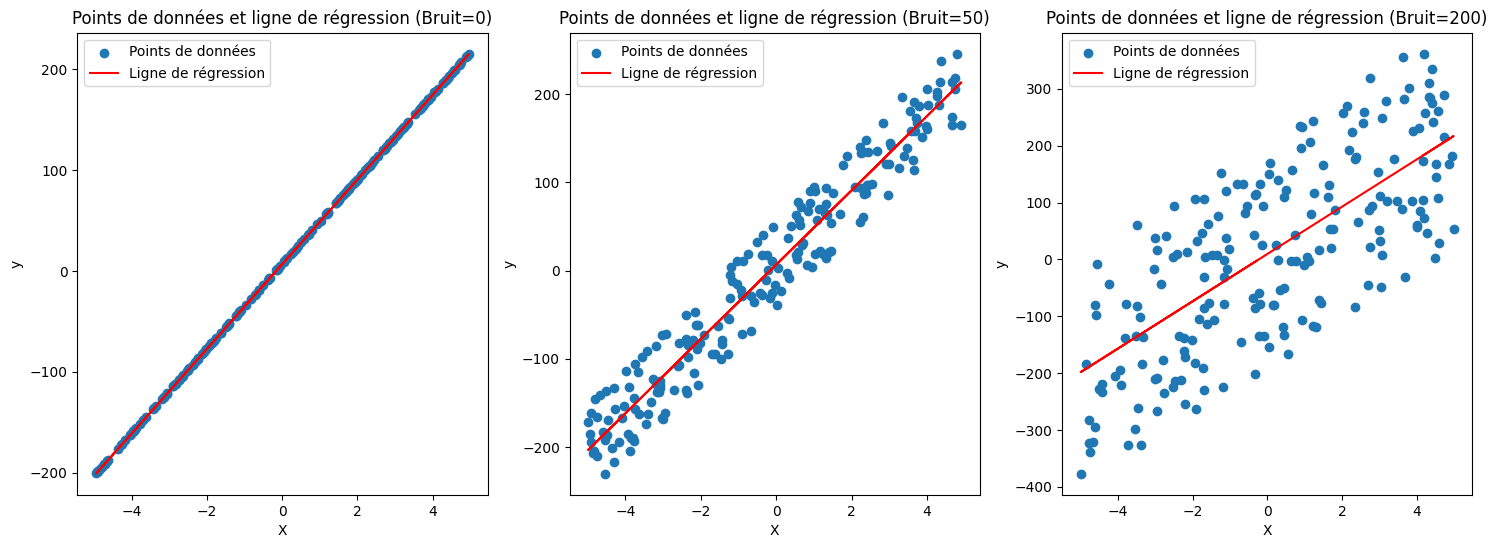

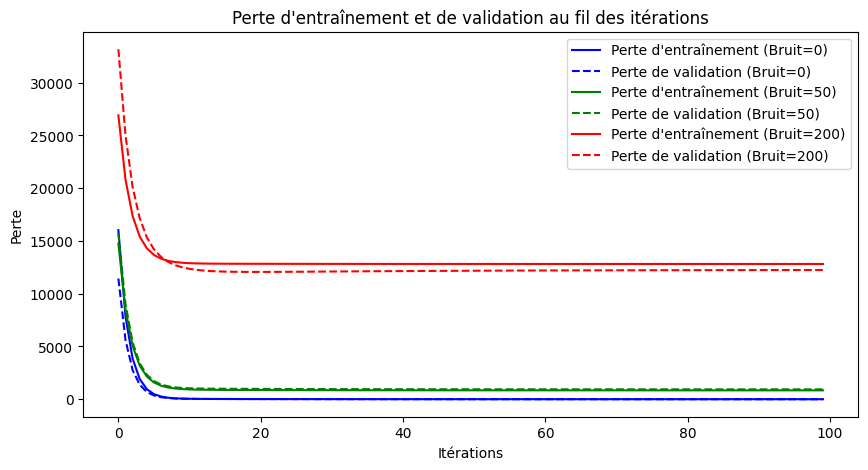

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Fonction de génération de données
def generate_data(a, b, noise_level, num_samples=200):
    X = np.random.uniform(-5, 5, num_samples).reshape((-1, 1))
    noise = np.random.uniform(-noise_level, noise_level, num_samples).reshape((-1, 1))
    y = a * X + b + noise
    return X, y

# Fonction d'exécution de l'expérience
def run_experiment(noise_level):
    # Générer des données
    X, y = generate_data(a=42, b=7, noise_level=noise_level, num_samples=200)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    n, d = X_train.shape[1], 1

    # Initialiser le modèle et la fonction de perte
    layer = Linear(n, d)
    loss = MSELoss()
        
    # Entraîner le modèle et collecter les pertes
    train_losses = []
    val_losses = []
    for _ in range(100):
        # Passe avant
        y_train_pred = layer.forward(X_train)
        y_val_pred = layer.forward(X_val)

        # Calculer la perte
        train_loss = loss.forward(y_train, y_train_pred).mean()
        val_loss = loss.forward(y_val, y_val_pred).mean()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Passe arrière
        loss_back = loss.backward(y_train, y_train_pred)
        delta_linear = layer.backward_delta(X_train, loss_back)
        layer.backward_update_gradient(X_train, loss_back)

        # Mettre à jour les paramètres
        layer.update_parameters(gradient_step=1e-4)
        layer.zero_grad()

    return X, y, layer.forward(X), train_losses, val_losses

# Exécuter des expériences avec trois niveaux de bruit différents
noise_levels = [0, 50, 200]
results = {}
for noise_level in noise_levels:
    results[noise_level] = run_experiment(noise_level)

# Tracer les points de données et les lignes de régression
plt.figure(figsize=(18, 6))
for i, noise_level in enumerate(noise_levels):
    X, y, y_pred, train_losses, val_losses = results[noise_level]
    plt.subplot(1, 3, i+1)
    plt.scatter(X, y, label='Points de données')
    plt.plot(X, y_pred, color='red', label='Ligne de régression')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'Points de données et ligne de régression (Bruit={noise_level})')
    plt.legend()
plt.show()

# Tracer les pertes d'entraînement et de validation
plt.figure(figsize=(10, 5))
colors = ['blue', 'green', 'red']
for i, noise_level in enumerate(noise_levels):
    train_losses, val_losses = results[noise_level][3], results[noise_level][4]
    plt.plot(train_losses, label=f'Perte d\'entraînement (Bruit={noise_level})', color=colors[i])
    plt.plot(val_losses, label=f'Perte de validation (Bruit={noise_level})', linestyle='--', color=colors[i])
plt.xlabel('Itérations')
plt.ylabel('Perte')
plt.title('Perte d\'entraînement et de validation au fil des itérations')
plt.legend()
plt.show()


### Classification

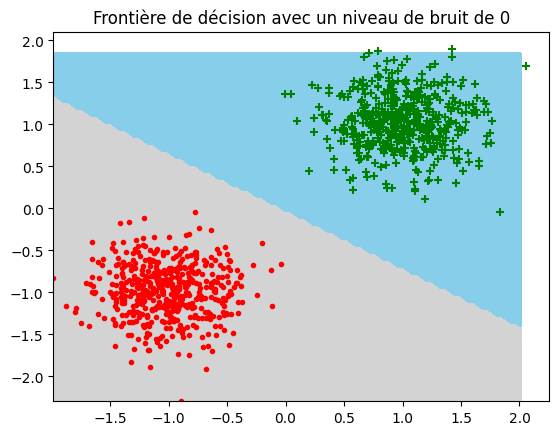

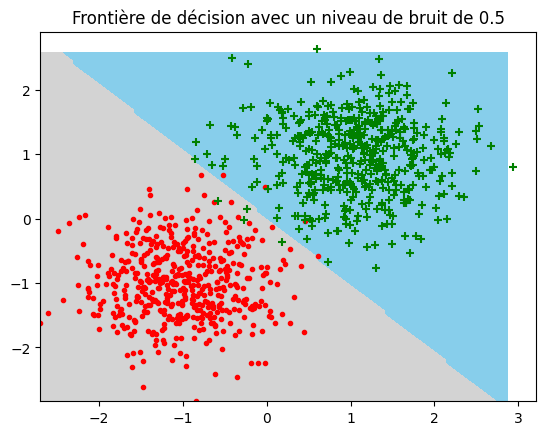

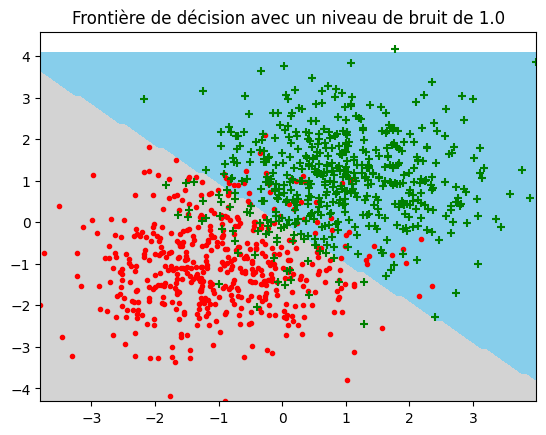

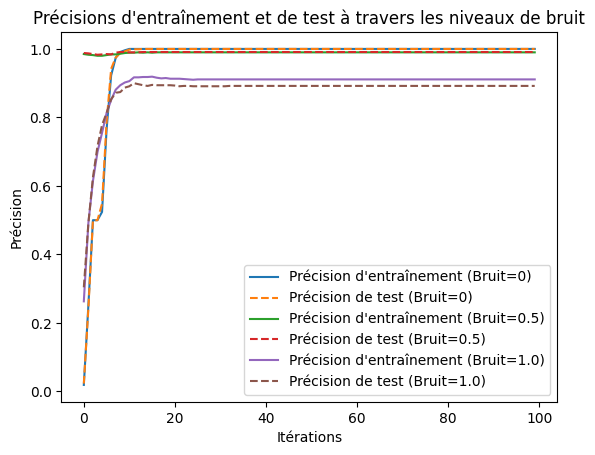

In [21]:
noise_levels = [0, 0.5, 1.0]  # Définir différents niveaux de bruit
results = {}  # Stocker les résultats pour chaque niveau de bruit
for epsilon in noise_levels:
    X_train, y_train = gen_arti(nbex=1000, data_type=0, epsilon=epsilon)
    X_test, y_test = gen_arti(nbex=1000, data_type=0, epsilon=epsilon)
    n = X_train.shape[1]
    d = 1

    y_train = np.where(y_train == -1, 0, 1).reshape((-1, 1))
    y_test = np.where(y_test == -1, 0, 1).reshape((-1, 1))

    # Paramètres
    iteration = 100
    gradient_step = 1e-4
    loss = MSELoss()
    layer = Linear(n, d, bias=True)

    # Listes pour stocker les pertes et les précisions
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Algorithme d'entraînement
    for _ in range(iteration):
        hidden_train = layer.forward(X_train)
        hidden_test = layer.forward(X_test)

        train_loss = loss.forward(y_train, hidden_train)
        test_loss = loss.forward(y_test, hidden_test)
        train_losses.append(train_loss.mean())
        test_losses.append(test_loss.mean())

        train_accuracy = (y_train == np.where(hidden_train >= 0.5, 1, 0)).mean()
        test_accuracy = (y_test == np.where(hidden_test >= 0.5, 1, 0)).mean()
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        loss_back = loss.backward(y_train, hidden_train)
        delta_linear = layer.backward_delta(X_train, loss_back)
        layer.backward_update_gradient(X_train, loss_back)
        layer.update_parameters(gradient_step=gradient_step)
        layer.zero_grad()

    # Stocker les résultats
    results[epsilon] = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies
    }
    plt.figure()
    # Tracer les frontières de décision et les données
    plot_frontiere(X_test, lambda x: np.where(layer.forward(x) >= 0.5, 1, 0), step=100)
    plot_data(X_test, y_test.reshape(-1))
    plt.title(f"Frontière de décision avec un niveau de bruit de {epsilon}")
    plt.show()
    
    
# Tracer la comparaison des précisions d'entraînement et de test pour différents niveaux de bruit
plt.figure()
for epsilon, data in results.items():
    plt.plot(np.arange(iteration), data['train_accuracies'], label=f'Précision d\'entraînement (Bruit={epsilon})')
    plt.plot(np.arange(iteration), data['test_accuracies'], label=f'Précision de test (Bruit={epsilon})', linestyle='--')
plt.xlabel('Itérations')
plt.ylabel('Précision')
plt.title('Précisions d\'entraînement et de test à travers les niveaux de bruit')
plt.legend()
plt.show()
